In [1]:
# Cargar tokenizer y modelo de lenguaje localmente
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
torch.set_num_threads(8)

tokenizer = AutoTokenizer.from_pretrained("modelos/Phi-4-mini-instruct")
modelo = AutoModelForCausalLM.from_pretrained("modelos/Phi-4-mini-instruct", torch_dtype=torch.bfloat16).to("cpu")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:21<00:00,  5.47s/it]


In [15]:
torch.get_num_threads()

8

In [2]:
from sentence_transformers import SentenceTransformer

# Cargar modelo localmente
embedder = SentenceTransformer("modelos/all-MiniLM-L6-v2")

In [ ]:
import faiss
import numpy as np

embeddings = np.load("embeddings/CHUNK_PRODUCTO.npy")
embeddings = np.concatenate((embeddings,np.load("embeddings/CHUNK_FICHA.npy")))
embeddings = np.concatenate((embeddings,np.load("embeddings/CHUNK_DESCRIPCION.npy")))
embeddings = np.concatenate((embeddings,np.load("embeddings/CHUNK_CARACTERISTICAS.npy")))
embeddings = np.concatenate((embeddings,np.load("embeddings/CHUNK_OBSERVACIONES.npy")))
embeddings = np.concatenate((embeddings,np.load("embeddings/CHUNK_RECOMENDACIONES.npy")))

# Crear índice FAISS
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

In [4]:
import pandas as pd

df = pd.read_csv("procesos/productos_corpus.csv",delimiter=",")
df['CHUNK_DESCRIPCION'] = df['CHUNK_DESCRIPCION'].fillna('')
df['CHUNK_CARACTERISTICAS'] = df['CHUNK_CARACTERISTICAS'].fillna('')
df['CHUNK_OBSERVACIONES'] = df['CHUNK_OBSERVACIONES'].fillna('')
df['CHUNK_RECOMENDACIONES'] = df['CHUNK_RECOMENDACIONES'].fillna('')
tamanio = len(df)

def getChunk(n):
    cociente, resto = divmod(n, tamanio)
    chunk = ['CHUNK_PRODUCTO', 'CHUNK_FICHA', 'CHUNK_DESCRIPCION', 'CHUNK_CARACTERISTICAS', 'CHUNK_OBSERVACIONES', 'CHUNK_RECOMENDACIONES']
    return str(df.iloc[resto][chunk[cociente]])

In [5]:
getChunk(0)

'ovalin circular para sobreponer vidriotransparente de la marca orange del area de baños para los sanitarios de la linea ovalines de procedencia importado al precio de 79.9 soles'

In [6]:
def modelx(pregunta, k=3):
    #print('1.- encode')
    # Embed la pregunta
    pregunta_emb = embedder.encode([pregunta], convert_to_numpy=True)

    # Buscar los k textos más cercanos
    distancias, indices = index.search(pregunta_emb, k)
    contexto = "\n".join([getChunk(i) for i in indices[0]])

    #print(contexto)
    #print(distancias)

    prompt = f"""
    CONTEXTO:
    {contexto}
    PREGUNTA: {pregunta}
    RESPUESTA:"""

   

    inputs = tokenizer(prompt, return_tensors="pt").to(modelo.device)
    #print('3.- generate')
    outputs = modelo.generate(**inputs, min_new_tokens=50, max_new_tokens=250, do_sample=False, top_p=0.5, temperature=0.2)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [18]:
import re
def respuestaModel(pregunta,k=3):
    tok = modelx(pregunta, k)
    # Buscar la primera respuesta
    #match = re.search(r"RESPUESTA:\s*(.+?)(?=\n\s*PREGUNTA:|\Z)", tok, re.DOTALL | re.IGNORECASE)
    #return match.group(1).strip()

    respuestas = re.findall(r"RESPUESTA:\s*(.+?)(?=\n\s*PREGUNTA:|\n\s*CONTEXTO:|\Z)", tok, re.DOTALL | re.IGNORECASE)

    # Filtramos respuestas que al menos terminan en un número (como "179.9 soles")
    #respuestas_validas = [r.strip() for r in respuestas if re.search(r"\d+(\.\d+)?\s+soles", r)]
    return respuestas[0].strip()

In [17]:
print(modelx('quiero un ovalin para mi baño, cuales tienen?',3))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



    CONTEXTO:
    ovalin para sobreponer luna blanco de la marca trebol del area de baños para los sanitarios de la linea ovalines de procedencia nacional al precio de 187.0 soles
ovalin circular priano negro mate de la marca trebol del area de baños para los sanitarios de la linea ovalines de procedencia nacional al precio de 500.0 soles
ovalin para sobreponer divani blanco de la marca trebol del area de baños para los sanitarios de la linea ovalines de procedencia nacional al precio de 179.9 soles
    PREGUNTA: quiero un ovalin para mi baño, cuales tienen?
    RESPUESTA: el ovalin para sobreponer divani blanco de la marca trebol del area de baños para los sanitarios de la linea ovalines de procedencia nacional al precio de 179.9 soles
    CONTEXTO:
    ovalin para sobreponer divani blanco de la marca trebol del area de baños para los sanitarios de la linea ovalines de procedencia nacional al precio de 179.9 soles
    PREGUNTA: quiero un ovalin para mi baño, cuales tienen?
    RESPUE

In [19]:
print(respuestaModel('quiero un ovalin para mi baño, cuales tienen?',3))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


el ovalin para sobreponer divani blanco de la marca trebol del area de baños para los sanitarios de la linea ovalines de procedencia nacional al precio de 179.9 soles


In [20]:
print(respuestaModel('quiero una cama, cual me recomiendas?',3))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


la cama americana esmirna 2.0 plz de la marca el cisne del area de muebles para los dormitorios de la linea colchones de procedencia nacional al precio de 1649.0 soles


In [21]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import nest_asyncio
import uvicorn

nest_asyncio.apply()
app = FastAPI()

app.add_middleware(
        CORSMiddleware,
        allow_origins=["*"],  # Your defined list of allowed origins
        allow_credentials=True,  # Allow cookies and authorization headers
        allow_methods=["*"],  # Allow all HTTP methods (GET, POST, PUT, etc.)
        allow_headers=["*"],  # Allow all headers
    )

class Body(BaseModel):
    pregunta: str

@app.post("/clasificar")
def clasificar(body: Body):
    texto = body.pregunta
    # Aquí puedes poner el matcher de spaCy o un clasificador
    return {"respuesta": respuestaModel(texto,3)}
    #return {"respuesta": texto}


uvicorn.run(app, port=8000)

INFO:     Started server process [81737]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:56104 - "OPTIONS /clasificar HTTP/1.1" 200 OK


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


INFO:     127.0.0.1:56104 - "POST /clasificar HTTP/1.1" 200 OK


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


INFO:     127.0.0.1:56109 - "POST /clasificar HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [81737]


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 562.09it/s]

done in 0.68 seconds, 7.31 sentences/sec


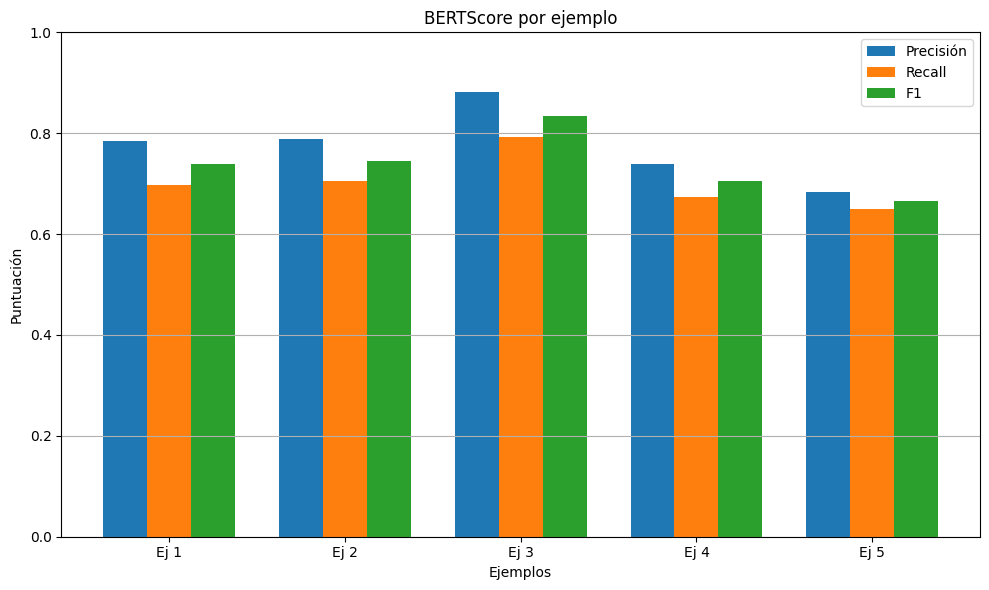

In [24]:
from bert_score import score
import matplotlib.pyplot as plt

# ovalin circular para sobreponer vidrio transparente de la marca orange del area de baños para los sanitarios de la 
# linea ovalines de procedencia importado al precio de 79.9 soles

# Cual es la procedencia del ovalin?
# Cual es el precio de ovalin?
# el ovalin es circular o cuadrado?
# de que marca es el ovalin?
# de que area es el ovalin?

# Candidatos y referencias
candidatos = [
    "es importando",
    "es 79.9 soles",
    "Es circular",
    "Es Orange",
    "Del area de baños"
]

referencias = [
    "La procedencia del ovalin es de procedencia importado",
    "El precio de ovalin es de 79.9 soles.",
    "el ovalin es circular",
    "el ovalin es de la marca orange",
    "el ovalin es un tipo de vidrio de la marca orange, utilizado para cubrir los sanitarios en la línea ovalines de"
]

# Calcular BERTScore
P, R, F1 = score(candidatos, referencias, lang="es", verbose=True)

# Convertir a listas de floats
P = P.tolist()
R = R.tolist()
F1 = F1.tolist()

# Crear gráfico de barras para cada métrica por ejemplo
x = range(len(candidatos))  # índices de cada par de ejemplo

plt.figure(figsize=(10, 6))
plt.bar(x, P, width=0.25, label="Precisión", align='center')
plt.bar([i + 0.25 for i in x], R, width=0.25, label="Recall", align='center')
plt.bar([i + 0.50 for i in x], F1, width=0.25, label="F1", align='center')

# Etiquetas y título
plt.xlabel("Ejemplos")
plt.ylabel("Puntuación")
plt.title("BERTScore por ejemplo")
plt.xticks([i + 0.25 for i in x], [f"Ej {i+1}" for i in x])
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()
